# Targeted particle delivery via ring vortex reconnection
In this notebook, we reproduce all the figures from the paper: 

In [1]:
# Required libraries to run the post-processing script
import sys
import os 
sys.path.append("/home/j/jphickey/josephmo/scratch/pencil-ind/python")
os.environ["PATH"] += os.pathsep +'/home/j/jphickey/josephmo/scratch/pencil-ind/bin'
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import optimize
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

width = 409
nice_fonts = {
  # Use LaTex to write all text
  "text.usetex": True,
  "font.family": "sans-serif",
  "font.serif": "FreeSans",
  # Use 10pt font in plots, to match 10pt font in document
  "axes.labelsize": 9,
  "font.size": 8.5,
  # Make the legend/label fonts a little smaller
  "legend.fontsize": 8,
  "xtick.labelsize": 8.5,
  "ytick.labelsize": 8.5,
}
matplotlib.rcParams.update(nice_fonts)

def set_fig(width, fraction=1,sidebyside=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) 

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio/sidebyside

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

#complete list of all of the cases
fileName={'S01U0':'st01'                ,'S1U0':'st1'                 , 'S10U0':'st10'                ,'S01U10':'st01_backflow_u001',
          'S01U25':'st01_backflow_u0025','S01U50':'st01_backflow_u005', 'S01U75':'st01_backflow_u0075','S1U0G':'st1_gap1'           ,            
          'S1U0G2':'st1_gap2'           ,'S1U05':'st1_backflow_u005'  , 'S1U25':'st1_backflow_u0025'  ,'S1U50':'st1_backflow_u005'  ,
          'S1U75':'st1_backflow_u0075'  ,'S01U0G':'st01_gap1'         , 'S01U0G2':'st01_gap2'         }

colorList=[ 'red', 'green', 'blue','fuchsia','red', 'green', 'blue','fuchsia']
lineList = ['-','-','-','-','-.','-.','-.','-.']

In [11]:
# User inputs
tot_tstep = 410
num_part  = 500
dim       =  3
num_cases = len(fileName)

#############################################################################
################### SAVE .PICKLE DATA INTO LOCAL VARIABLES ##################
#############################################################################
time = np.zeros(tot_tstep)

pos    = np.zeros([dim,num_part,tot_tstep,num_cases])
vel    = np.zeros([dim,num_part,tot_tstep,num_cases])
mpos   = np.zeros([dim,tot_tstep,num_cases])
stdpos = np.zeros([dim,tot_tstep,num_cases])
mvel   = np.zeros([dim,tot_tstep,num_cases])

#mapping time to space
nbbins   = 60
bins     = np.linspace(0, 2*np.pi, nbbins )
mpos_space= np.zeros([dim,nbbins,num_cases])
stdpos_space= np.zeros([dim,nbbins,num_cases])


timespace   =  [None] * num_cases
time_vs_pos =  [None] * num_cases

masterDict = {}

Xc=0;Yc=1;Zc=2
correct_x = 3.1416

for case_counter,case in enumerate(fileName):
    masterDict[case]=case_counter
    pickle_in=open(fileName[case]+'.pickle','rb')
    data=pickle.load(pickle_in)
    pickle_in.close()
    
    time[:]                   = data['time']
    
    pos[Xc,:,:,case_counter]  = data['part_zp'] + correct_x  #pencil swaps x/z axis
    pos[Yc,:,:,case_counter]  = data['part_yp']
    pos[Zc,:,:,case_counter]  = data['part_xp']

    #a few cases loop around, we correct here
    if case in ['S01U50','S01U75','S1U50','S1U75']:
        temp=copy(pos[Xc,:,:,case_counter])
        for i in range(len(tot_tstep)):
            if min(temp.flatten())<2 and max(temp.flatten())<6:
                
                
    
    mpos[Xc,:,case_counter]   = np.mean(data['part_zp']+ correct_x,axis=0)
    mpos[Yc,:,case_counter]   = np.mean(abs(data['part_yp']),axis=0)
    mpos[Zc,:,case_counter]   = np.mean(abs(data['part_xp']),axis=0)
    
    stdpos[Xc,:,case_counter] = np.std(data['part_zp']+ correct_x,axis=0)
    stdpos[Yc,:,case_counter] = np.std(abs(data['part_yp']),axis=0)
    stdpos[Zc,:,case_counter] = np.std(abs(data['part_xp']),axis=0)
    
    timespace[case_counter] = interp1d(time[:], mpos[Xc,:,case_counter])
    
    inds = np.digitize(pos[Xc,:,:,case_counter], bins)
    mpos_space[Xc,:,case_counter] = [np.mean(abs(pos[Xc,inds[:, :] == i,case_counter])) for i in range(len(bins))]
    mpos_space[Yc,:,case_counter] = [np.mean(abs(pos[Yc,inds[:, :] == i,case_counter])) for i in range(len(bins))]   
    mpos_space[Zc,:,case_counter] = [np.mean(abs(pos[Zc,inds[:, :] == i,case_counter])) for i in range(len(bins))]      

    stdpos_space[Xc,:,case_counter] = [np.std(abs(pos[Xc,inds[:, :] == i,case_counter])) for i in range(len(bins))]
    stdpos_space[Yc,:,case_counter] = [np.std(abs(pos[Yc,inds[:, :] == i,case_counter])) for i in range(len(bins))]   
    stdpos_space[Zc,:,case_counter] = [np.std(abs(pos[Zc,inds[:, :] == i,case_counter])) for i in range(len(bins))]  
    
    time_vs_pos[case_counter] = interp1d(time,mpos[Xc,:,case_counter], kind='cubic') #f(time)=average position

1.5363617592860086


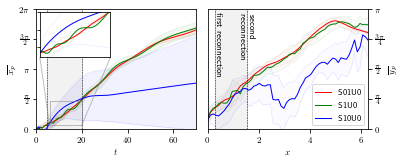

In [48]:
###############################################################################
############ FIGURE 2: PARTICLE MEAN POSITION + STD. DEV. VS. TIME ############
###############################################################################
fig, (ax1, ax2) = plt.subplots(1,2, figsize=set_fig(width,sidebyside=3))

cases=['S01U0','S1U0','S10U0']

ax1.fill_between([5,20],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency
ax2.fill_between([time_vs_pos[masterDict[cases[0]]](5),time_vs_pos[masterDict[cases[0]]](20)],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency

# time evolution in the x-direction
for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax1.fill_between(time, mpos[Xc,:,ii]+stdpos[Xc,:,ii],mpos[Xc,:,ii]-stdpos[Xc,:,ii],
                 facecolor=colorList[jj], #fill color
                 color=colorList[jj], #outline color
                 alpha=0.05) #fill transparency
  ax1.plot(time, mpos[Xc,:,ii]+stdpos[Xc,:,ii], colorList[jj], alpha=0.25, lw = 0.2 )
  ax1.plot(time, mpos[Xc,:,ii]-stdpos[Xc,:,ii], colorList[jj], alpha=0.25, lw = 0.2 )
  ax1.plot(time, mpos[Xc,:,ii], colorList[jj], lw = 1, label=case)

ax1.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,2*math.pi)
ax1.set_yticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi])
ax1.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

#Inset figure
axins = ax1.inset_axes([0.025, 0.6, 0.44, 0.375])
cases_inset=['S01U0','S1U0','S10U0']
for jj,case in enumerate(cases_inset):
  ii=masterDict[case]
  axins.plot(time, mpos[Xc,:,ii]+stdpos[Xc,:,ii], colorList[jj], alpha=0.25, lw = 0.2 )
  axins.plot(time, mpos[Xc,:,ii]-stdpos[Xc,:,ii], colorList[jj], alpha=0.25, lw = 0.2 )
  axins.plot(time, mpos[Xc,:,ii], colorList[jj], lw = 1, label=case)
  
axins.set_xlim(6, 20)
axins.set_ylim(0.2, 1.5)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xticks([])
ax1.indicate_inset_zoom(axins)

#spatial evolution in y
for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax2.fill_between(bins, mpos_space[Yc,:,ii]+stdpos_space[Yc,:,ii],mpos_space[Yc,:,ii]-stdpos_space[Yc,:,ii],
                 facecolor=colorList[jj], #fill color
                 color=colorList[jj], #outline color
                 alpha=0.02) #fill transparency
  ax2.plot(bins, mpos_space[Yc,:,ii]+stdpos_space[Yc,:,ii], colorList[jj], alpha=0.25, lw = 0.2)
  ax2.plot(bins, mpos_space[Yc,:,ii]-stdpos_space[Yc,:,ii], colorList[jj], alpha=0.25, lw = 0.2)
  ax2.plot(bins, mpos_space[Yc,:,ii], colorList[jj], lw = 1, label=case)
  ax2.yaxis.set_label_position("right")
  ax2.yaxis.tick_right()

ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](5), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](20), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\overline{y_p}$')
ax2.text(0.3,1.4,'first reconnection',rotation=-90)
ax2.text(1.58,2.4,'second',rotation=-90)
ax2.text(1.25,1.85,'reconnection',rotation=-90)
ax2.set_xlim(0,2*math.pi)
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
plt.legend()
plt.tight_layout()
plt.savefig('figure_02.pdf')
plt.show()

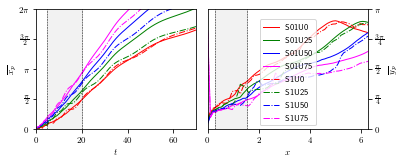

In [45]:
####################################################################################################
###################### FIGURE 4: MEAN y_p & z_p VS. t: ST01 & ST1 CHANNEL FLOW #####################
####################################################################################################
fig, (ax1, ax2) = plt.subplots(1,2, figsize=set_fig(width,sidebyside=3))

ax1.fill_between([5,20],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency
ax2.fill_between([time_vs_pos[masterDict[cases[0]]](5),time_vs_pos[masterDict[cases[0]]](20)],[10,10],
                 facecolor='grey', #fill color
                 color='grey', #outline color
                 alpha=0.1) #fill transparency

cases=['S01U0','S01U25','S01U50','S01U75','S1U0','S1U25','S1U50','S1U75']
for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax1.plot(time, mpos[Xc,:,ii], colorList[jj],linestyle=lineList[jj], lw = 1, label=case)
ax1.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,2*math.pi)
ax1.set_yticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi])
ax1.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

for jj,case in enumerate(cases):
  ii=masterDict[case]
  ax2.plot(bins, mpos_space[Yc,:,ii], colorList[jj],linestyle=lineList[jj], lw = 1, label=case)
  ax2.yaxis.set_label_position("right")
  ax2.yaxis.tick_right()
    
ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](5), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.axvline(x=time_vs_pos[masterDict[cases[0]]](20), ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\overline{y_p}$')
ax2.set_xlim(0,2*math.pi)
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
plt.legend()
plt.tight_layout()
plt.savefig('figure_04.pdf')
plt.show()

NameError: name 'dicts' is not defined

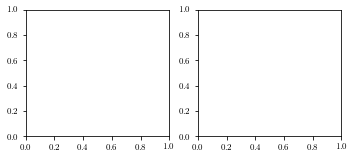

In [42]:
###################################################################################################
################### FIGURE 5: MEAN y_p & z_p vs. t: ST01 & ST1 GAP VS. NO GAP #####################
###################################################################################################

fig, (ax1, ax2) = plt.subplots(1,2, figsize=set_fig(width,sidebyside=3))

cases=['S01U0','S1U0','S01U0G','S1U0G']
for jj,case in enumerate(cases):
  ii=dicts[case]
  ax1.plot(time, mpos[Xc,:,ii], colorList[jj],linestyle=lineList[jj], lw = 1, label=case)
ax1.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\overline{x_p}$')
ax1.set_xlim(0,time[350])
ax1.set_ylim(0,2*math.pi)
ax1.set_yticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi])
ax1.set_yticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

for jj,case in enumerate(cases):
  ii=dicts[case]
  ax2.plot(time, mpos[Yc,:,ii], colorList[jj],linestyle=lineList[jj], lw = 1, label=case)
  ax2.yaxis.set_label_position("right")
  ax2.yaxis.tick_right()
    
ax2.axvline(x=5, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.axvline(x=20, ymin=0, ymax=1, c = 'k', ls = '--', lw = 0.5)
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\overline{y_p}$')
ax2.set_xlim(0,time[350])
ax2.set_ylim(0,math.pi)
ax2.set_yticks([0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi])
ax2.set_yticklabels([r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
plt.legend()
plt.tight_layout()
plt.savefig('figure_05.pdf')
plt.show()

In [ ]:
##################################################################
################### CONTOUR SCATTER FOR ST01 #####################
##################################################################

##################################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################
mycase = 'S01U0'
pickle_in=open('st01_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

z = data['x']
y = data['y']
x = data['z']+correct_x

L2 = data['L2']

##################################
############ PLOTTING ############
##################################
Y, X = np.meshgrid(y, x)
plt.figure(figsize=set_fig(width,sidebyside=3))
for ii in range(len(save_flowfield_times)):
  plt.contour(X,Y,L2[:,:,1,ii],[-0.1], colors = 'red', linestyles = 'solid')
save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2


for ii,time in enumerate(save_flowfield_times):
   psnap=int(time*5)  #Note for time indexing: 1 index = 0.2 seconds, i.e. index of 50 corresponds to 10 seconds
   zpoints=pos[Zc,:,psnap,masterDict[mycase]]
   select= np.where(abs(zpoints)<0.075)
   plt.scatter(pos[Xc,select,psnap,masterDict[mycase]],pos[Yc,select,psnap,masterDict[mycase]],alpha=0.05)
   plt.scatter(np.mean(pos[Xc,select,psnap,masterDict[mycase]]),np.mean(abs(pos[Yc,select,psnap,masterDict[mycase]])))
   plt.scatter(np.mean(pos[Xc,select,psnap,masterDict[mycase]]),-np.mean(abs(pos[Yc,select,psnap,masterDict[mycase]])))

plt.xlim(0,2*np.pi)
plt.xlabel('$x$')
plt.ylabel('$y$')


plt.savefig('st01_scatter_isosurfaces.pdf',bbox_inches='tight')

In [ ]:
##################################################################
################### CONTOUR SCATTER FOR ST1 ######################
##################################################################

##################################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################

from lambda2 import *

pickle_in=open('st1_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

##################################
############ PLOTTING ############
##################################

Y, Z = np.meshgrid(y, z)

plt.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2

plt.scatter(part_zp[:,50,1],part_yp[:,50,1], s = 0.5, color = 'red')
plt.scatter(part_zp[:,100,1],part_yp[:,100,1], s = 0.5, color = 'blue')
plt.scatter(part_zp[:,150,1],part_yp[:,150,1], s = 0.5, color = 'green')
plt.scatter(part_zp[:,200,1],part_yp[:,200,1], s = 0.5, color = 'magenta')
plt.scatter(part_zp[:,300,1],part_yp[:,300,1], s = 0.5, color = 'black')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-math.pi,math.pi)
plt.ylim(-math.pi,math.pi)

ytick_pos= np.linspace(-math.pi,math.pi,5)
ylabels = [r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(ytick_pos, ylabels)
xtick_pos= np.linspace(-math.pi,math.pi,5)
xlabels = [r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(xtick_pos, xlabels)

plt.savefig('st1_scatter_isosurfaces.pdf',bbox_inches='tight')

In [ ]:
##################################################################
################### CONTOUR SCATTER FOR ST10 #####################
##################################################################

##################################################################
############ EXTRACTING .PICKLE DATA & CALCULATING L2 ############
##################################################################
from lambda2 import *

pickle_in=open('st10_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

##################################
############ PLOTTING ############
##################################

Y, Z = np.meshgrid(y, z)

plt.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
plt.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

save_flowfield_snaps = np.zeros(len(save_flowfield_times))

for i in range(len(save_flowfield_times)):
    save_flowfield_snaps[i] = save_flowfield_times[i]/0.2

plt.scatter(part_zp[:,50,2],part_yp[:,50,2], s = 0.5, color = 'red')
plt.scatter(part_zp[:,150,2],part_yp[:,150,2], s = 0.5, color = 'green')
plt.scatter(part_zp[:,300,2],part_yp[:,300,2], s = 0.5, color = 'black')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-math.pi,math.pi)
plt.ylim(-math.pi,math.pi)

ytick_pos= np.linspace(-math.pi,math.pi,5)
ylabels = [r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(ytick_pos, ylabels)
xtick_pos= np.linspace(-math.pi,math.pi,5)
xlabels = [r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.xticks(xtick_pos, xlabels)

plt.savefig('st10_scatter_isosurfaces.pdf',bbox_inches='tight')

print('Done')

In [ ]:
####################################################################
################### FIGURE 3: CONTOUR SCATTER ######################
####################################################################

#######################################
############ FIGURE SIZING ############
#######################################

fraction = 1
# Width of figure
fig_width_pt = width * fraction
# Convert from pt to inches
inches_per_pt = 1 / 72.27
# Golden ratio to set aesthetic figure height
golden_ratio = (5**.5 - 1) / 2
# Figure width in inches
fig_width_in = fig_width_pt * inches_per_pt
# Figure height in inches
fig_height_in = fig_width_in * golden_ratio * 3 + 0.5
fig_dim = (fig_width_in, fig_height_in)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize = fig_dim)

##############################
############ ST01 ############
##############################
from lambda2 import *

pickle_in=open('st01_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax1.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
ax1.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax1.scatter(part_zp[:,50,0],part_yp[:,50,0], s = 0.25, color = 'red')
ax1.scatter(part_zp[:,100,0],part_yp[:,100,0], s = 0.25, color = 'blue')
ax1.scatter(part_zp[:,150,0],part_yp[:,150,0], s = 0.25, color = 'green')
ax1.scatter(part_zp[:,200,0],part_yp[:,200,0], s = 0.25, color = 'magenta')
ax1.scatter(part_zp[:,300,0],part_yp[:,300,0], s = 0.25, color = 'black')

ax1.set_ylabel(r'$y$')
ax1.set_xlim(-math.pi,math.pi)
ax1.set_ylim(-math.pi,math.pi)

ax1.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax1.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 0.1$', loc=2)
ax1.add_artist(anchored_text)

##############################
############ ST1 #############
##############################
from lambda2 import *

pickle_in=open('st1_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax2.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,2],[-0.005], colors = 'blue', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,4],[-0.005], colors = 'magenta', linestyles = 'solid')
ax2.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax2.scatter(part_zp[:,50,1],part_yp[:,50,1], s = 0.25, color = 'red')
ax2.scatter(part_zp[:,100,1],part_yp[:,100,1], s = 0.25, color = 'blue')
ax2.scatter(part_zp[:,150,1],part_yp[:,150,1], s = 0.25, color = 'green')
ax2.scatter(part_zp[:,200,1],part_yp[:,200,1], s = 0.25, color = 'magenta')
ax2.scatter(part_zp[:,300,1],part_yp[:,300,1], s = 0.25, color = 'black')

ax2.set_ylabel(r'$y$')
ax2.set_xlim(-math.pi,math.pi)
ax2.set_ylim(-math.pi,math.pi)

ax2.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax2.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 1$', loc=2)
ax2.add_artist(anchored_text)

##############################
############ ST10 ############
##############################

from lambda2 import *

pickle_in=open('st10_flowfield.pickle','rb')
data=pickle.load(pickle_in)
pickle_in.close()

save_flowfield_times = [0,10,20,30,40,50,60]

L2 = np.zeros((512,256,3,len(save_flowfield_times)))

x = data['x']
y = data['y']
z = data['z']

for n in range(len(save_flowfield_times)):
    for k in range(512):
        for j in range(256):
            for i in range(3):
                L2[k,j,i,n] = data['L2'][k,j,i,n]

Y, Z = np.meshgrid(y, z)

ax3.contour(Z,Y,L2[:,:,1,1],[-0.05], colors = 'red', linestyles = 'solid')
ax3.contour(Z,Y,L2[:,:,1,3],[-0.05], colors = 'green', linestyles = 'solid')
ax3.contour(Z,Y,L2[:,:,1,6],[-0.005], colors = 'black', linestyles = 'solid')

ax3.scatter(part_zp[:,50,2],part_yp[:,50,2], s = 0.25, color = 'red')
ax3.scatter(part_zp[:,150,2],part_yp[:,150,2], s = 0.25, color = 'green')
ax3.scatter(part_zp[:,300,2],part_yp[:,300,2], s = 0.25, color = 'black')

ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$y$')
ax3.set_xlim(-math.pi,math.pi)
ax3.set_ylim(-math.pi,math.pi)

ax3.set_yticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax3.set_yticklabels([r'$-\pi$', r'$\frac{-\pi}{2}$', r'0', r'$\frac{\pi}{2}$', r'$\pi$'])

ax3.set_xticks([-math.pi,-math.pi/2,0,math.pi/2,math.pi])
ax3.set_xticklabels([r'0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

from matplotlib.offsetbox import AnchoredText
anchored_text = AnchoredText('$St = 10$', loc=2)
ax3.add_artist(anchored_text)

from matplotlib.lines import Line2D
colors = ['red', 'blue', 'green', 'magenta', 'black']
lines = [Line2D([0], [0], color=c, linewidth=1, linestyle='-') for c in colors]
labels = ['10', '20', '30','40','60']

plt.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, -0.35),
          ncol=5, title = '$t$', fancybox=False, shadow=False, framealpha = 1, edgecolor = '0')

plt.savefig('st01_st1_st10_scatter_isosurfaces.pdf',bbox_inches='tight')